# Flow-Matching Posterior Estimation (FMPE) and Neural Posterior Score Estimation (NPSE)
`sbi` also incorporates recent algorithms based on Flow Matching and Score Matching generative models, which are also referred to as Continuous Normalizing Flows (CNF) and Denoising Diffusion Probabilistic Models (DDPM), respectively.

At the highest level, you can conceptualize FMPE and NPSE as tackling the exact same problem as (S)NPE, i.e., estimating the posterior from simulations, but replacing Normalizing Flows with different conditional density estimators. 

Flow Matching and Score Matching, as generative models, are also quite similar to Normalizing Flows, where a deep neural network parameterizes the transformation from a base distribution (e.g., Gaussian) to a more complex one that approximates the target density, but they differ in what this transformation looks like (more on that below). 

Beyond that, Flow Matching and Score Matching offer different benefits and drawbacks compared to Normalizing Flows, which make them better (or worse) choices for some problems. For examples, Score Matching (Diffusion Models) are known to be very flexible and can model high-dimensional distributions, but are comparatively slow during sampling.

In this tutorial, we take a brief look at the API for `FMPE` and `NPSE`, their pros and cons, as well as highlight some notable options.

For more information, see:

**Score Matching**:
- Hyvärinen, A. "Estimation of Non-Normalized Statistical Models by Score Matching." JMLR 2005.
- Song, Y., et al. "Score-Based Generative Modeling through Stochastic Differential Equations." ICLR 2021.
- Geffner, T., Papamakarios, G., and Mnih, A. "Score modeling for simulation-based inference." NeurIPS 2022 Workshop on Score-Based Methods. 2022.
- Sharrock, L., Simons, J., et al. "Sequential neural score estimation: Likelihood-free inference with conditional score based diffusion models." ICML 2024.

**Flow Matching**:
- Lipman, Y., et al. "Flow Matching for Generative Modeling." ICLR 2023
- Wildberger, J.B., Dax, M. Buchholz, S., et al. "Flow Matching for Scalable Simulation-Based Inference." NeurIPS 2023.

In [1]:
import torch

from sbi.inference import NPSE, simulate_for_sbi
from sbi.utils import BoxUniform
from sbi import analysis as analysis

/opt/miniconda3/envs/sbi_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
# Example toy simulator
import torch

# Define the prior
num_dims = 3
num_sims = 1000
prior = BoxUniform(low=torch.zeros(num_dims), high=torch.ones(num_dims))
def simulator(theta):
    # linear gaussian
    return theta + 1.0 + torch.randn_like(theta) * 0.1
# x_o = torch.tensor([0.5, 0.5, 0.5])

# Produce simulations
theta = prior.sample((num_sims,))
x = simulator(theta)

theta_o = prior.sample((1,))
x_o = simulator(theta_o)

# FMPE
(Might make more sense to put this second since CNF was introduced as a simplification of diffusion models)

---

# NPSE
NPSE approximates the posterior distribution by learning its score function, i.e., gradient of the log-density, using the denoising score matching loss. The class of generative models is referred to as score-based generative models, with close links to diffusion models.

- Score-based generative models have been shown to scale well to very high dimensions (e.g., high-resolutions images), which is particularly useful when the parameter space (and hence, the target posterior) is high-dimensional.
- On the other hand, sampling can be slower as it involves solving many steps of the stochastic differential equation for reversing the diffusion process.

Note that only the single-round version of NPSE is implemented currently.

For more details on score-based generative models, see [Song et al., 2020](https://arxiv.org/abs/2011.13456) (in particular, Figure 1 and 2).

In [3]:
# Instantiate NPSE and append simulations
inference = NPSE(prior=prior, sde_type="ve")
_ = inference.append_simulations(theta, x)

Note the argument `sde_type`, which defines whether the forward diffusion process has a noising schedule that is Variance Exploding (`ve`, i.e., [SMLD](https://proceedings.neurips.cc/paper/2019/hash/3001ef257407d5a371a96dcd947c7d93-Abstract.html?ref=https://githubhelp.com)), Variance Preserving (`vp`, i.e., [DDPM](https://proceedings.neurips.cc/paper/2020/hash/4c5bcfec8584af0d967f1ab10179ca4b-Abstract.html)), or sub-Variance Preserving (`subvp`) in the limit.

In [4]:
# Train the score estimator
score_estimator = inference.train()

 Neural network successfully converged after 585 epochs.

In [5]:
# Build the posterior using the trained score estimator, and sample
posterior = inference.build_posterior(score_estimator)
# posterior.sample((1,), x=x_o)
posterior_samples = posterior.sample((10000,), x=x_o)

/Users/rdgao/Documents/code/sbi/sbi/inference/posteriors/score_posterior.py:73: UserWarning: x_shape is not None. However, passing x_shape to the `Posterior` is deprecated and will be removed in a future release of `sbi`.
  super().__init__(
Drawing 10000 posterior samples: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 499/499 [00:01<00:00, 254.58it/s]


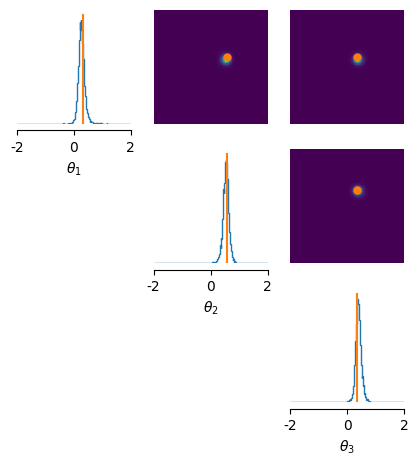

In [6]:
# plot posterior samples
_ = analysis.pairplot(
    posterior_samples, limits=[[-2, 2], [-2, 2], [-2, 2]], figsize=(5, 5),
    labels=[r"$\theta_1$", r"$\theta_2$", r"$\theta_3$"],
    points=theta_o # add ground truth thetas
)

In [7]:
# Or, more compactly:
inference = NPSE(prior, sde_type="ve")
_ = inference.append_simulations(theta, x).train()
posterior = inference.build_posterior().set_default_x(x_o)

 Neural network successfully converged after 684 epochs.